# Load data

In [44]:
import xarray as xr

data_dir = 'D:/VScode/Last_deglaciation/data'
ds_sat_EOFs = xr.open_dataset(data_dir + '/ds_sat_EOFs.nc')
# ds_sat_EOFs.info

sat_centered_weighted = ds_sat_EOFs['sat_centered_weighted'].values
sat_centered_weighted = sat_centered_weighted.reshape(len(ds_sat_EOFs['age']), 96*144)
print('shape of the reshaped sat_centered_weighted:', sat_centered_weighted.shape)



ds_seaice = xr.open_dataset('D:/VScode/Last_deglaciation/data/ds_seaice.nc')
sic_centered_weighted = ds_seaice['sic_centered_weighted'].values
sic_centered_weighted = sic_centered_weighted.reshape(len(ds_seaice['age']), 96*144)

print('shape of the reshaped sic_centered_weighted:', sic_centered_weighted.shape)

shape of the reshaped sat_centered_weighted: (65, 13824)
shape of the reshaped sic_centered_weighted: (65, 13824)


# Doing CCA, only for the area of the Southern Ocean class

## The lat lon pairs are generated in notebook 'LGME_SEAICE_ana.ipynb'

In [45]:
# load the lat_lon_pairs
import numpy as np
path='D:/VScode/Last_deglaciation/data/lat_lon_pairs.npy'
lat_lon_pairs=np.load(path, allow_pickle=True)
lat_lon_pairs

array([[-78.63158 , 182.5     ],
       [-76.73684 , 165.      ],
       [-76.73684 , 167.5     ],
       ...,
       [ 72.947365, 117.5     ],
       [ 72.947365, 120.      ],
       [ 72.947365, 125.      ]], dtype=float32)

# Check data

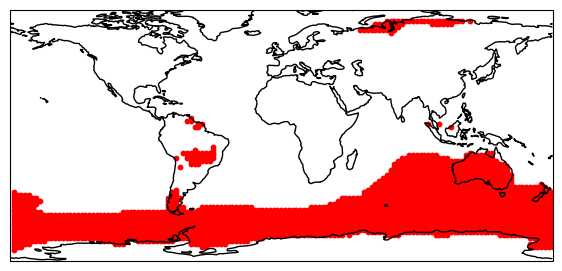

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


# Separate latitudes and longitudes from the pairs
lats, lons = zip(*lat_lon_pairs)

# Create a figure and axis with a global map projection
fig, ax = plt.subplots(figsize=(7, 3.5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.COASTLINE)

# Plot the lat-lon pairs as red dots
ax.scatter(lons, lats, color='red', s=10, transform=ccrs.PlateCarree())

# Display the plot
plt.show()


# Extract sat and sic data in this region

In [47]:
import numpy as np
import xarray as xr

def extract_data(ds, variable,lat_lon_pairs):
    # Initialize a list to store the sic data
    data_list = []
    
    # Loop through each lat-lon pair to extract the sic data
    for lat, lon in lat_lon_pairs:
        # Find the integer index corresponding to the lat and lon values
        lat_idx = np.argmin(np.abs(ds['lat'].values - lat))
        lon_idx = np.argmin(np.abs(ds['lon'].values - lon))
        
        # Extract sic data for dims=0 and age[:] for the current lat-lon pair
        # using integer-based indexing
        # if variable=='sic_centered_weighted':
        #     data = ds[variable].isel(dims=1,lat=lat_idx, lon=lon_idx).values
        # if variable=='sat_centered_weighted':
        data = ds[variable].isel(lat=lat_idx, lon=lon_idx).values
        
        # Append this data to our list
        data_list.append(data)
        
    # Convert list to a NumPy array for convenience
    data_array = np.array(data_list)
    
    return data_array


In [48]:
sat_SO_data = extract_data(ds_sat_EOFs, 'sat_centered_weighted', lat_lon_pairs)
sic_SO_data = extract_data(ds_seaice, 'sic_centered_weighted', lat_lon_pairs)

In [13]:
sat_SO_data.shape

(2451, 65)

# Doing CCA
ref: https://saturncloud.io/blog/canonical-correlation-analysis-in-python-with-sklearn/\
https://cmdlinetips.com/2020/12/canonical-correlation-analysis-in-python/\
https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.CCA.html
https://medium.com/@pozdrawiamzuzanna/canonical-correlation-analysis-simple-explanation-and-python-example-a5b8e97648d2

In [49]:
sat_SO_data.T.shape

(65, 2451)

In [50]:
from sklearn.cross_decomposition import CCA
cca = CCA(scale=False,n_components=2)
# cca.fit(sat_SO_data.T, sic_SO_data.T)
U,V=cca.fit_transform(sat_SO_data.T, sic_SO_data.T)
print(U.shape)
print(V.shape)

(65, 2)
(65, 2)


In [51]:
print('Corrcoef between U1 and V1',np.corrcoef(U[:, 0], V[:, 0]))
print('Corrcoef between U1 and V1',np.corrcoef(U[:, 1], V[:, 1]))

Corrcoef between U1 and V1 [[1. 1.]
 [1. 1.]]
Corrcoef between U1 and V1 [[1. 1.]
 [1. 1.]]


# Plot U and V

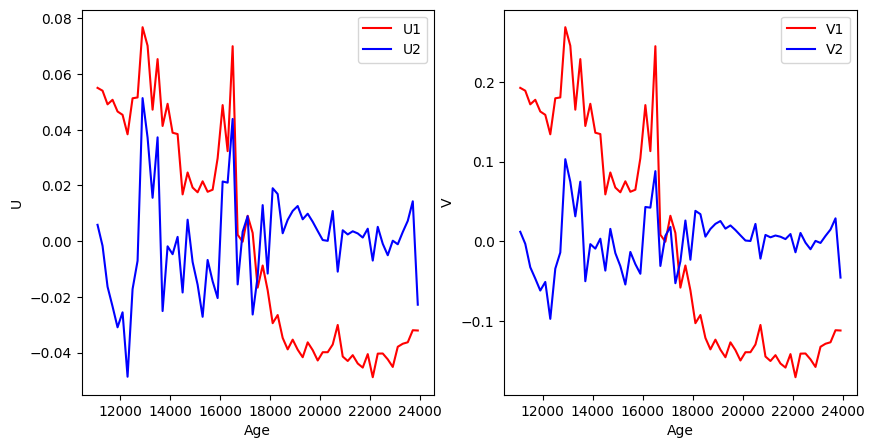

In [52]:
# plot U1 and U2
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(ds_sat_EOFs['age'].values,U[:, 0], color='red', label='U1')
plt.plot(ds_sat_EOFs['age'].values,U[:, 1], color='blue', label='U2')
plt.xlabel('Age')
plt.ylabel('U')
plt.legend()

# plot V1 and V2
plt.subplot(1,2,2)
plt.plot(ds_sat_EOFs['age'].values,V[:, 0], color='red', label='V1')
plt.plot(ds_sat_EOFs['age'].values,V[:, 1], color='blue', label='V2')
plt.xlabel('Age')
plt.ylabel('V')
plt.legend()

# Correct the direction of U and U

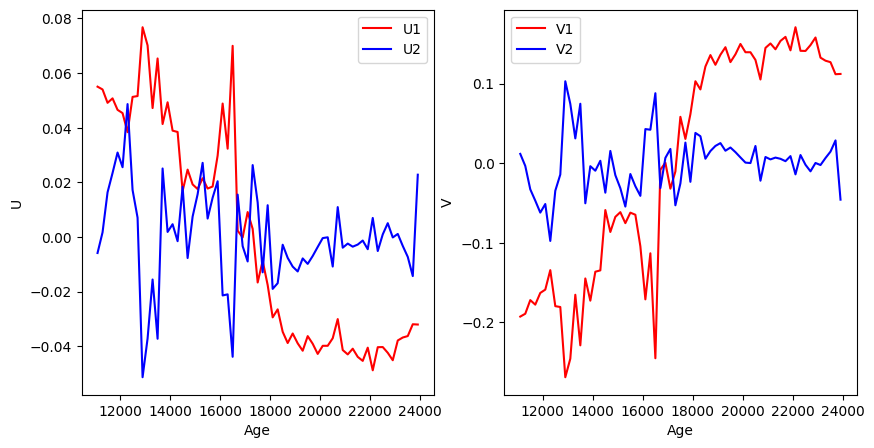

In [58]:
corr_U1=1
corr_U2=-1
corr_V1=-1
corr_V2=1

U1_corr=corr_U1*U[:, 0]
U2_corr=corr_U2*U[:, 1]
V1_corr=corr_V1*V[:, 0]
V2_corr=corr_V2*V[:, 1]

# plot U1 and U2
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(ds_sat_EOFs['age'].values,U1_corr, color='red', label='U1')
plt.plot(ds_sat_EOFs['age'].values,U2_corr, color='blue', label='U2')
plt.xlabel('Age')
plt.ylabel('U')
plt.legend()

# plot V1 and V2
plt.subplot(1,2,2)
plt.plot(ds_sat_EOFs['age'].values,V1_corr, color='red', label='V1')
plt.plot(ds_sat_EOFs['age'].values,V2_corr, color='blue', label='V2')
plt.xlabel('Age')
plt.ylabel('V')
plt.legend()


# Plot the correlations

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


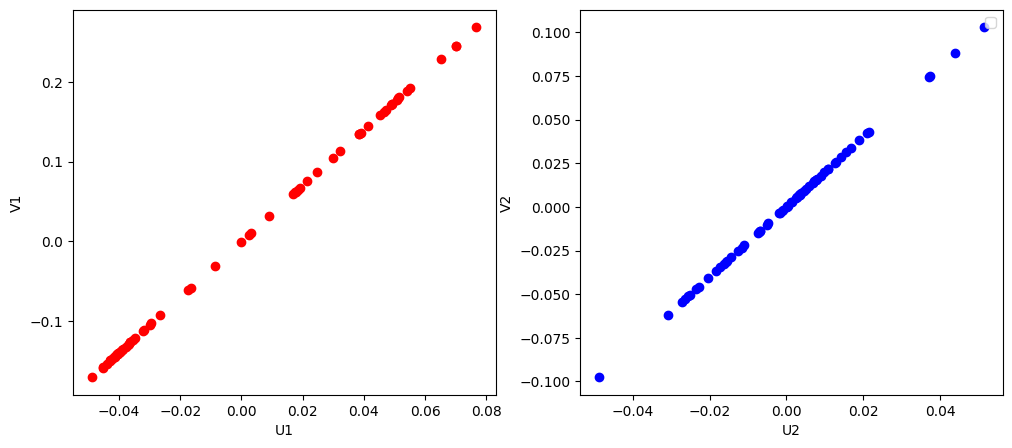

In [53]:
# plot canonical variates

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(U[:, 0], V[:, 0], color='red')
plt.xlabel('U1')
plt.ylabel('V1')

plt.subplot(1,2,2)
plt.scatter(U[:, 1], V[:, 1], color='blue')
plt.xlabel('U2')
plt.ylabel('V2')
plt.legend()


# Verification, see whether we can get U by X*a

In [54]:
weight_SO_sat=cca.x_weights_
weight_SO_sic=cca.y_weights_



In [55]:
weight_SO_sat.shape

(2451, 2)

(65, 2)


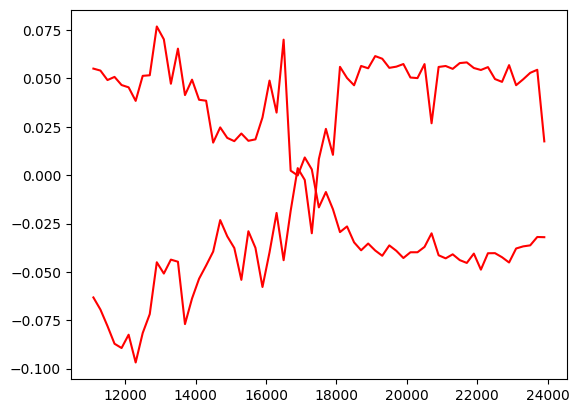

In [56]:
U_test=sat_SO_data.T.dot(weight_SO_sat)
print(U_test.shape)
# plot U_Ver
plt.figure()
# plt.plot(ds_sat_EOFs['age'].values,zscore(U_ver), color='red', label='U_ver')
plt.plot(ds_sat_EOFs['age'].values,U_test, color='red', label='U_ver')

# Get loadings

In [19]:
loading_SO_sat=cca.x_loadings_
loading_SO_sic=cca.y_loadings_

loading_SO_sat1=loading_SO_sat[:, 0] 
loading_SO_sat2=loading_SO_sat[:, 1]
loading_SO_sic1=loading_SO_sic[:, 0]
loading_SO_sic2=loading_SO_sic[:, 1]

In [59]:
# correct loadings
loading_SO_sat1_corr=corr_U1*loading_SO_sat1
loading_SO_sat2_corr=corr_U2*loading_SO_sat2
loading_SO_sic1_corr=corr_V1*loading_SO_sic1
loading_SO_sic2_corr=corr_V2*loading_SO_sic2

In [20]:
loading_SO_sat.shape

(2451, 2)

# Plot loading

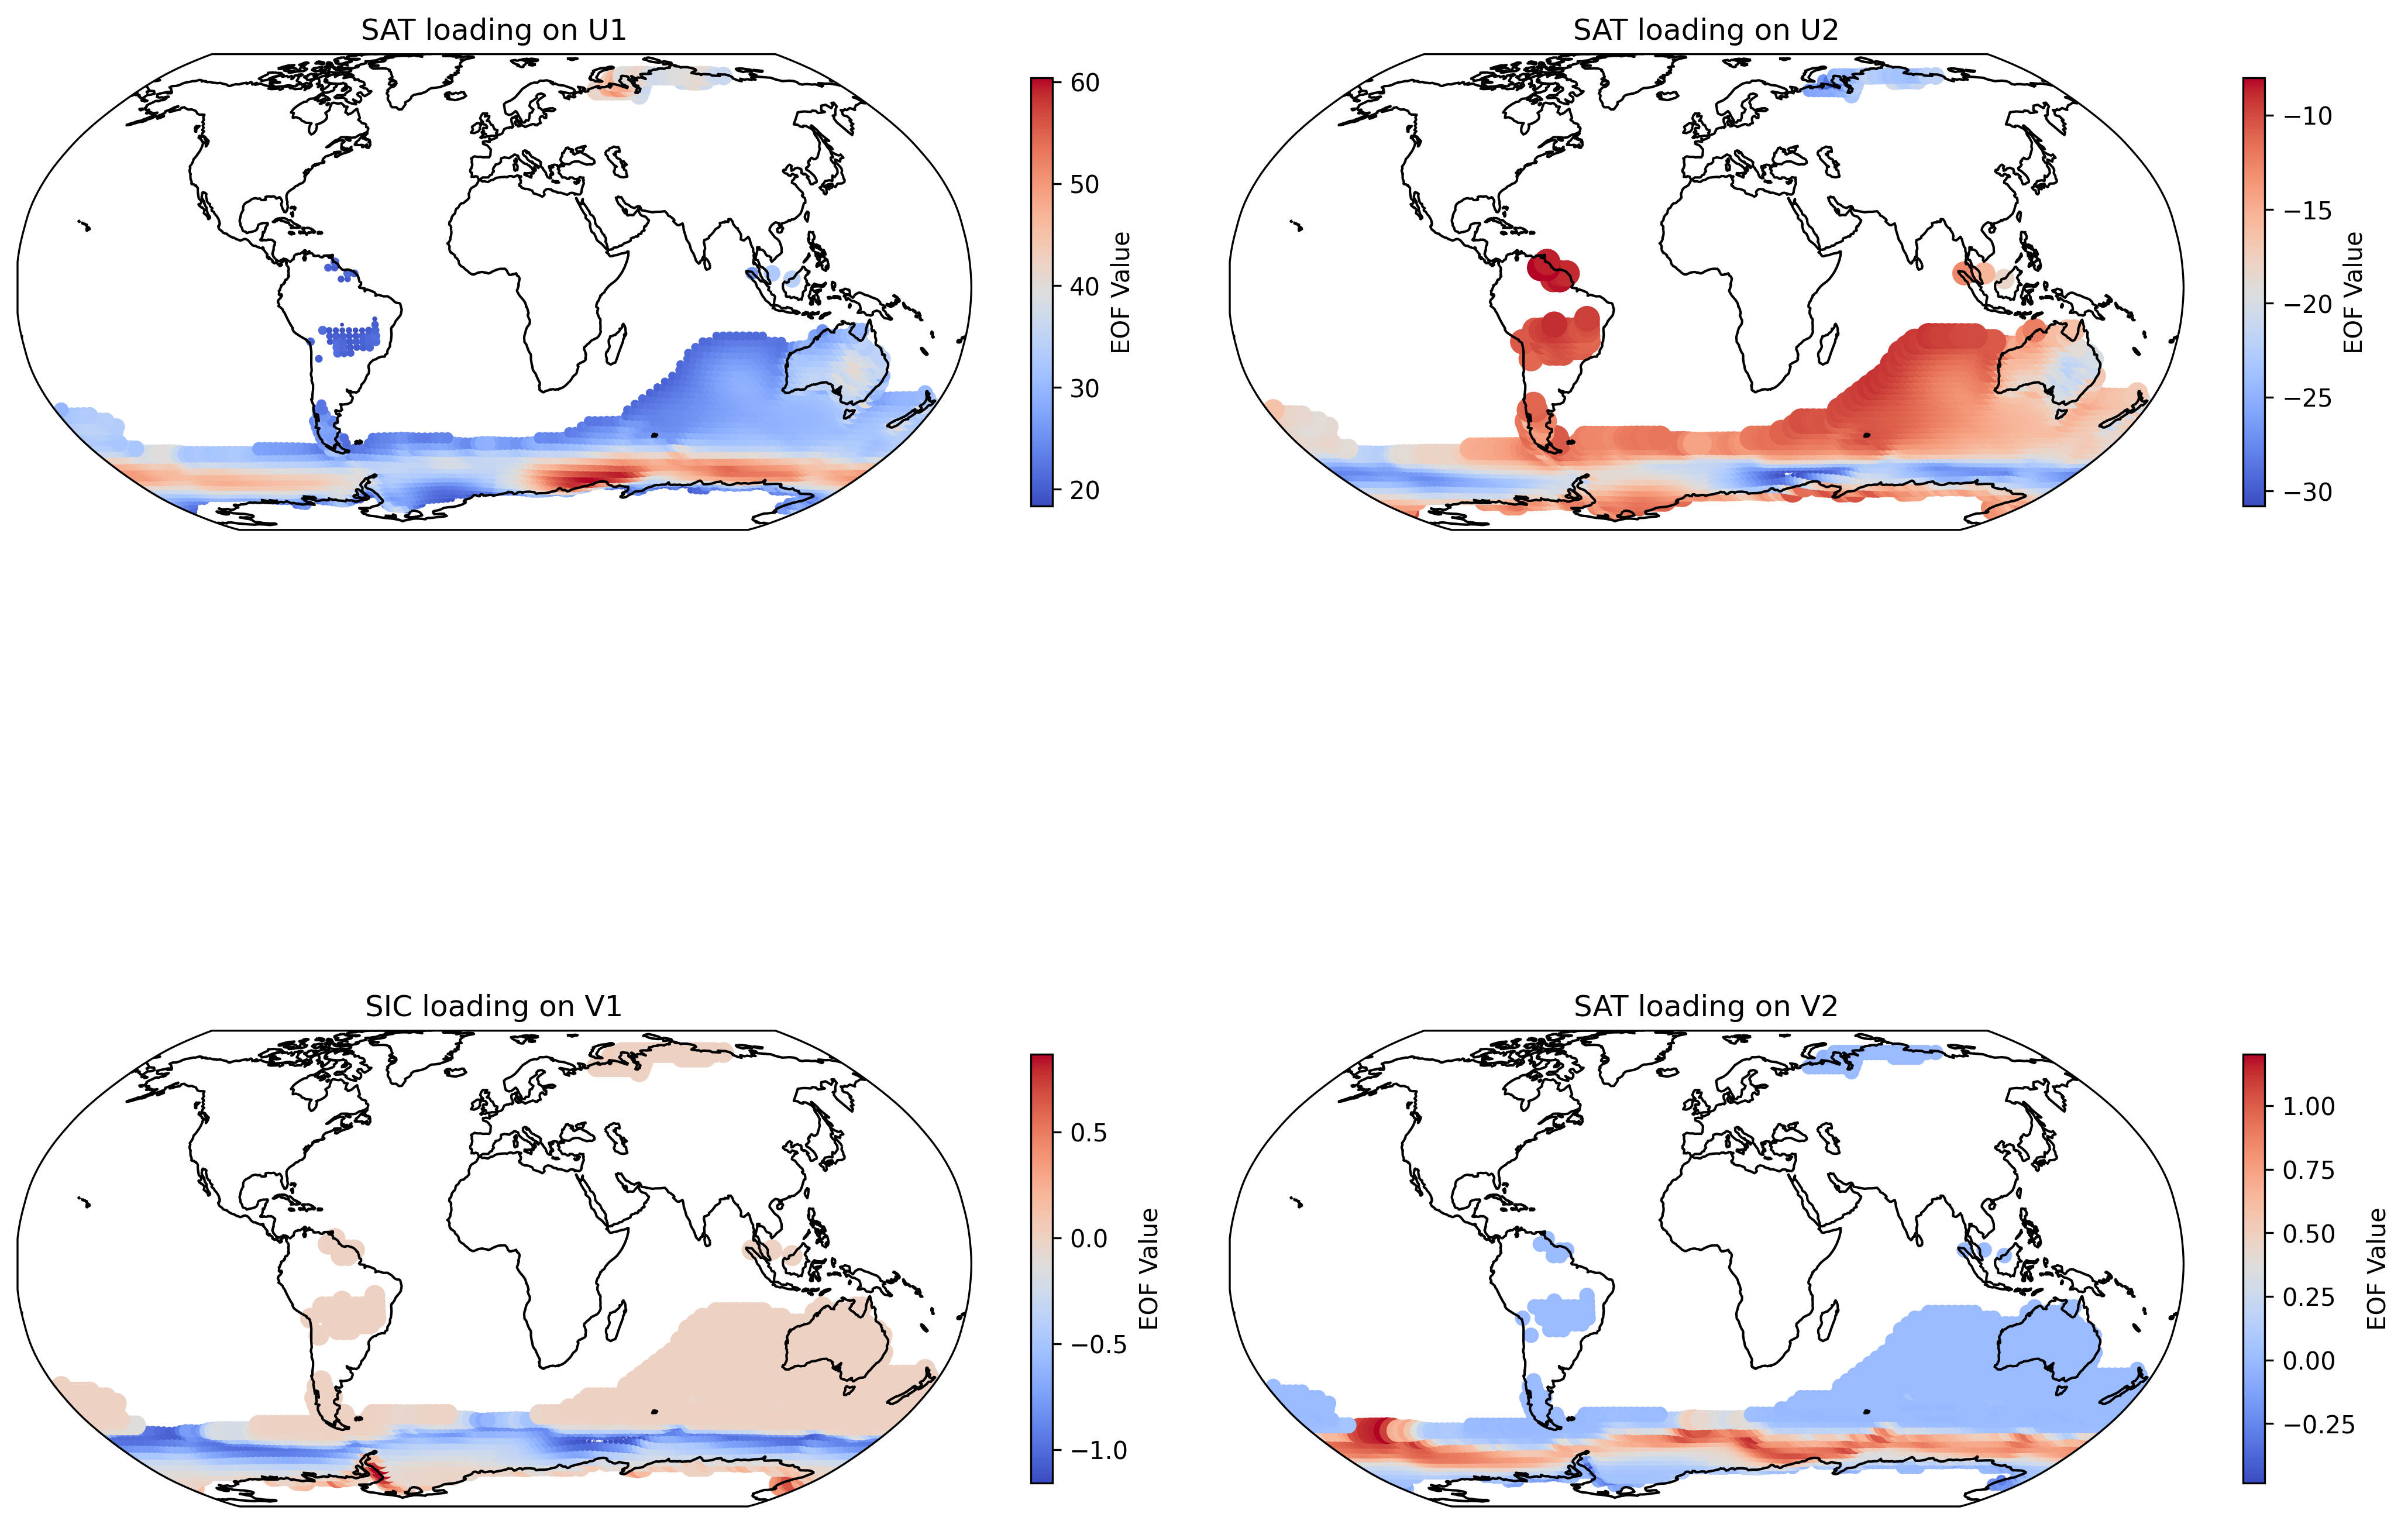

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Separate latitudes and longitudes from the pairs
lats, lons = zip(*lat_lon_pairs)

# List of EOFs to plot
eofs_list = [loading_SO_sat1, loading_SO_sat2, loading_SO_sic1, loading_SO_sic2]
titles = ['SAT loading on U1', 'SAT loading on U2', 'SIC loading on V1', 'SAT loading on V2']
# Create a figure and axes with a global map projection
fig, axs = plt.subplots(2, 2, figsize=(14, 14), dpi=300, subplot_kw=dict(projection=ccrs.Robinson()))

for i, ax in enumerate(axs.ravel()):
    eof = eofs_list[i]
    title = titles[i]

    # Normalizing the EOF values for size. This could be adapted per subplot if needed.
    eof_sizes = (eof - eof.min()) / (eof.max() - eof.min()) * 100

    ax.add_feature(cfeature.COASTLINE)
    scatter = ax.scatter(lons, lats, c=eof, s=eof_sizes, transform=ccrs.PlateCarree(), cmap='coolwarm')
    
    # Add a colorbar to each subplot
    cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.05, shrink=0.3)
    cbar.ax.set_ylabel('EOF Value')
    
    ax.set_title(title)

# Adjust the layout
fig.tight_layout()
plt.show()


# Plot corrected loadings

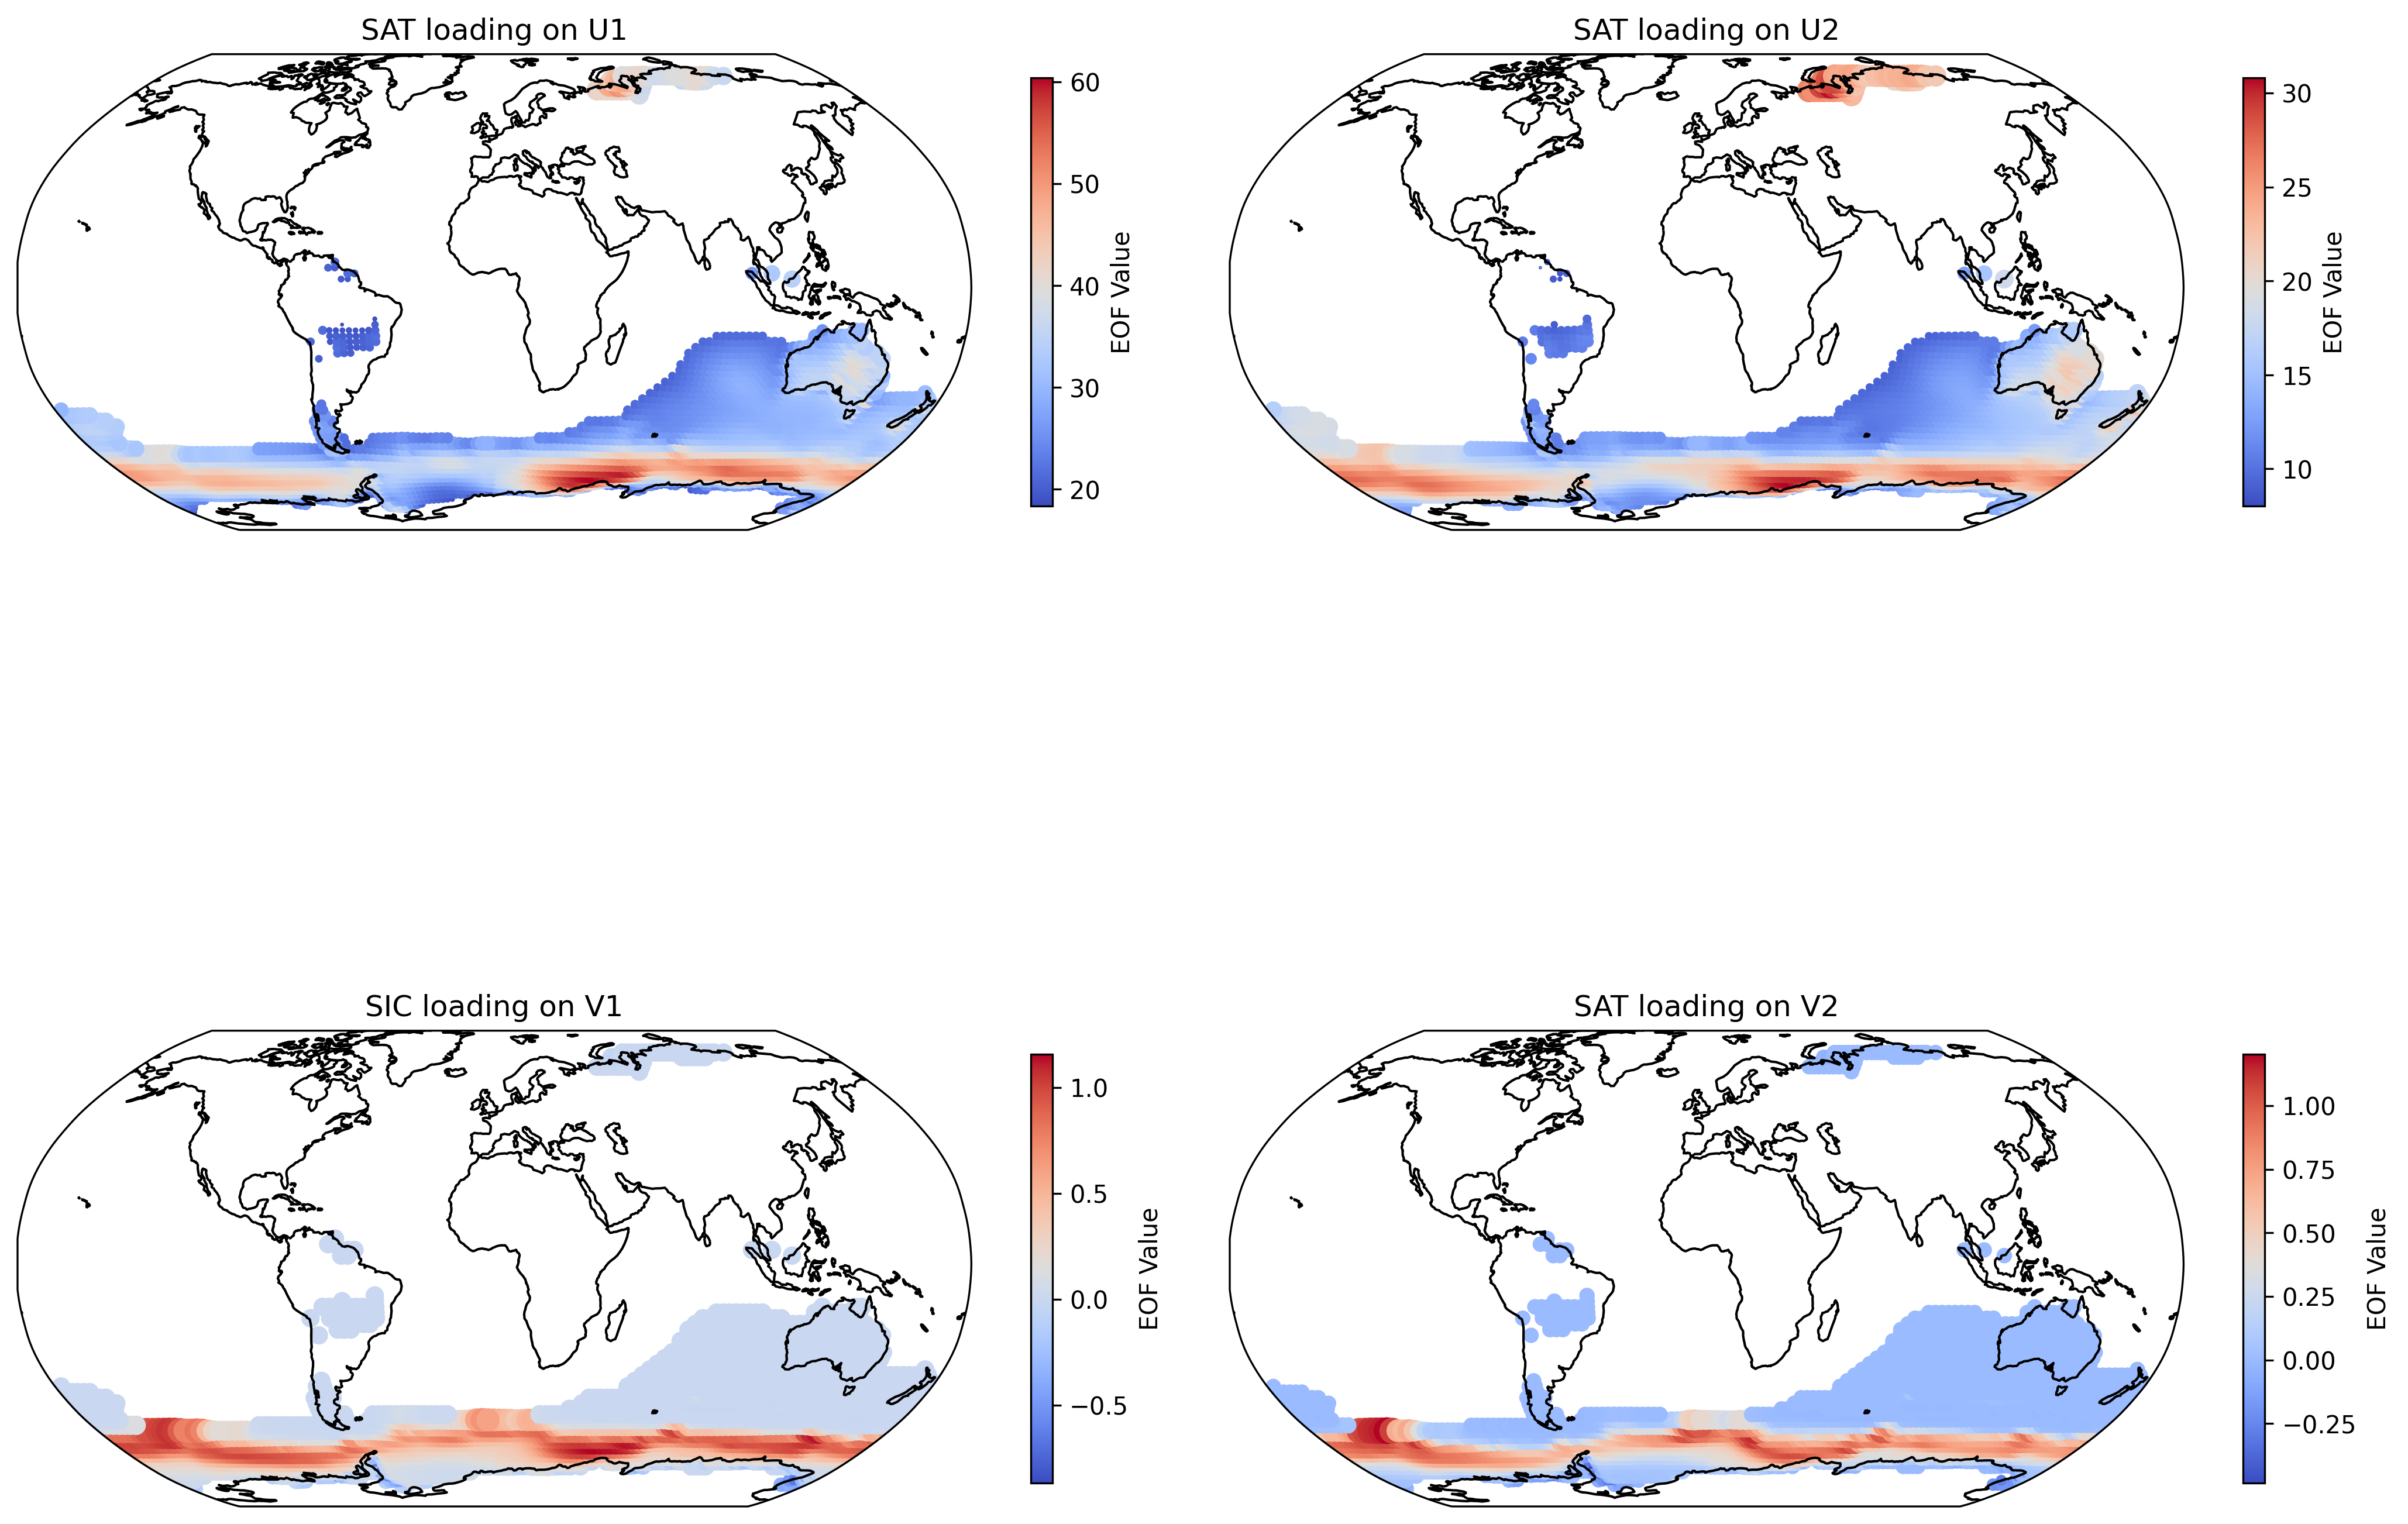

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Separate latitudes and longitudes from the pairs
lats, lons = zip(*lat_lon_pairs)

loading_list = [loading_SO_sat1_corr, loading_SO_sat2_corr, loading_SO_sic1_corr, loading_SO_sic2_corr]
titles = ['SAT loading on U1', 'SAT loading on U2', 'SIC loading on V1', 'SAT loading on V2']
# Create a figure and axes with a global map projection
fig, axs = plt.subplots(2, 2, figsize=(14, 14), dpi=300, subplot_kw=dict(projection=ccrs.Robinson()))

for i, ax in enumerate(axs.ravel()):
    loading = loading_list[i]
    title = titles[i]

    # Normalizing the EOF values for size. This could be adapted per subplot if needed.
    loading_sizes = (loading - loading.min()) / (loading.max() - loading.min()) * 100

    ax.add_feature(cfeature.COASTLINE)
    scatter = ax.scatter(lons, lats, c=loading, s=loading_sizes, transform=ccrs.PlateCarree(), cmap='coolwarm')
    
    # Add a colorbar to each subplot
    cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.05, shrink=0.3)
    cbar.ax.set_ylabel('EOF Value')
    
    ax.set_title(title)

# Adjust the layout
fig.tight_layout()
plt.show()


In [21]:
sat_SO_data.T.shape

(65, 2451)

# Calculate loading*data to verify

(65, 2)


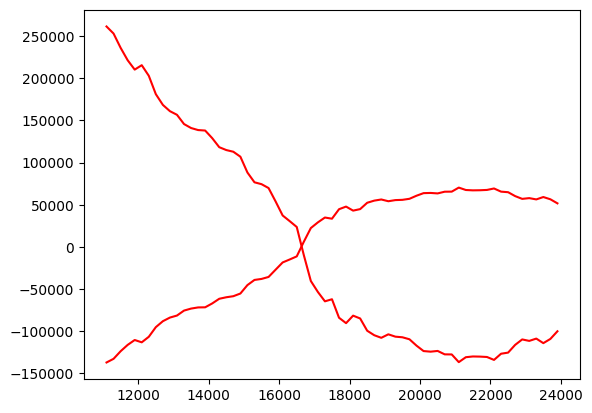

In [25]:
from scipy.stats import zscore

U_ver=sat_SO_data.T.dot(loading_SO_sat)
print(U_ver.shape)
# plot U_Ver
plt.figure()
# plt.plot(ds_sat_EOFs['age'].values,zscore(U_ver), color='red', label='U_ver')
plt.plot(ds_sat_EOFs['age'].values,U_ver, color='red', label='U_ver')


In [27]:
import numpy as np

# Generate made-up data
np.random.seed(42)
X = np.random.randn(100, 3) + np.array([0, 2, 4])  # 100 samples, 3 variables
Y = X @ np.array([
    [0.5, 1.5], 
    [1.5, 2.0], 
    [2.0, 1.0]
]) + np.random.randn(100, 2) * 0.5  # 100 samples, 2 variables

# Compute covariance matrices
S_xx = np.cov(X, rowvar=False)
S_yy = np.cov(Y, rowvar=False)
S_xy = np.cov(X, Y, rowvar=False)[:X.shape[1], X.shape[1]:]
S_yx = S_xy.T

# Solve the generalized eigenvalue problem for X
left = np.linalg.inv(S_xx) @ S_xy @ np.linalg.inv(S_yy) @ S_yx
eigenvalues, eigenvectors = np.linalg.eig(left)

# The eigenvectors provide weights for the canonical variables for X
max_eigen_index = np.argmax(eigenvalues)
a = eigenvectors[:, max_eigen_index]
print("Weights for X:", a)

# Calculate canonical weights for Y
lambda_max = eigenvalues[max_eigen_index]
b = np.linalg.inv(S_yy) @ S_yx @ a / lambda_max
print("Weights for Y:", b)

# Canonical variables
u = X @ a
v = Y @ b

print("Canonical correlation:", np.corrcoef(u, v)[0, 1])


Weights for X: [0.41167954 0.70924457 0.57226926]
Weights for Y: [0.17955283 0.22647658]
Canonical correlation: 0.987976784003896


In [28]:
import numpy as np
from sklearn.cross_decomposition import CCA

# Generate made-up data
np.random.seed(42)
X = np.random.randn(100, 3) + np.array([0, 2, 4])  # 100 samples, 3 variables
Y = X @ np.array([
    [0.5, 1.5], 
    [1.5, 2.0], 
    [2.0, 1.0]
]) + np.random.randn(100, 2) * 0.5  # 100 samples, 2 variables

# Perform CCA
cca = CCA(n_components=2)
cca.fit(X, Y)

# Transform data to canonical space
X_c, Y_c = cca.transform(X, Y)

# Canonical coefficients
print("Weights for X:", cca.x_weights_)
print("Weights for Y:", cca.y_weights_)

# Canonical correlation
canonical_correlations = np.corrcoef(X_c.T, Y_c.T, rowvar=True)[:2, 2:]
print("Canonical correlations:\n", canonical_correlations)


Weights for X: [[ 0.33489739 -0.57010733]
 [ 0.6905016  -0.39325752]
 [ 0.6411328   0.72133637]]
Weights for Y: [[ 0.66456778  0.74722799]
 [ 0.74722799 -0.66456778]]
Canonical correlations:
 [[ 9.87972393e-01  3.15098652e-16]
 [-1.02162407e-03  9.26655969e-01]]


In [30]:
X

array([[ 0.49671415,  1.8617357 ,  4.64768854],
       [ 1.52302986,  1.76584663,  3.76586304],
       [ 1.57921282,  2.76743473,  3.53052561],
       [ 0.54256004,  1.53658231,  3.53427025],
       [ 0.24196227,  0.08671976,  2.27508217],
       [-0.56228753,  0.98716888,  4.31424733],
       [-0.90802408,  0.5876963 ,  5.46564877],
       [-0.2257763 ,  2.0675282 ,  2.57525181],
       [-0.54438272,  2.11092259,  2.84900642],
       [ 0.37569802,  1.39936131,  3.70830625],
       [-0.60170661,  3.85227818,  3.98650278],
       [-1.05771093,  2.82254491,  2.77915635],
       [ 0.2088636 ,  0.04032988,  2.67181395],
       [ 0.19686124,  2.73846658,  4.17136828],
       [-0.11564828,  1.6988963 ,  2.52147801],
       [-0.71984421,  1.53936123,  5.05712223],
       [ 0.34361829,  0.23695984,  4.32408397],
       [-0.38508228,  1.323078  ,  4.61167629],
       [ 1.03099952,  2.93128012,  3.16078248],
       [-0.30921238,  2.33126343,  4.97554513],
       [-0.47917424,  1.81434102,  2.893

In [35]:
# normaliz each column of X
X_norm = (X - X.mean(axis=0)) / X.std(axis=0)
X_norm

array([[ 4.93439239e-01,  4.61603061e-02,  5.17340053e-01],
       [ 1.74402998e+00, -5.22690072e-02, -2.79011884e-01],
       [ 1.81249029e+00,  9.75852610e-01, -4.91538532e-01],
       [ 5.49303576e-01, -2.87606868e-01, -4.88156860e-01],
       [ 1.83017852e-01, -1.77587837e+00, -1.62529439e+00],
       [-7.96980164e-01, -8.51575049e-01,  2.16218628e-01],
       [-1.21826859e+00, -1.26163023e+00,  1.25601706e+00],
       [-3.86933017e-01,  2.57404552e-01, -1.35421958e+00],
       [-7.75162723e-01,  3.01948517e-01, -1.10699945e+00],
       [ 3.45978124e-01, -4.28463047e-01, -3.30989813e-01],
       [-8.45013279e-01,  2.08943513e+00, -7.97583137e-02],
       [-1.40066567e+00,  1.03242274e+00, -1.17007910e+00],
       [ 1.42686307e-01, -1.82349718e+00, -1.26701701e+00],
       [ 1.28061139e-01,  9.46117052e-01,  8.71885533e-02],
       [-2.52739338e-01, -1.20992939e-01, -1.40278120e+00],
       [-9.88966824e-01, -2.84754328e-01,  8.87088163e-01],
       [ 3.06888192e-01, -1.62165820e+00

In [38]:
u_derived = X @ cca.x_weights_
v_derived = Y @ cca.y_weights_
zscore(u_derived)

array([[ 0.57957391,  0.15341836],
       [ 0.26710893, -0.94913293],
       [ 0.87444868, -1.50406319],
       [-0.42230636, -0.50002689],
       [-2.49453681, -0.65537779],
       [-0.69292114,  0.81220559],
       [-0.31672959,  1.91592741],
       [-0.97105584, -0.93093167],
       [-0.8638395 , -0.59364904],
       [-0.46469597, -0.24417873],
       [ 1.21206933, -0.43676912],
       [-0.56568876, -0.62866261],
       [-2.26524674, -0.35419849],
       [ 0.79620636, -0.32861362],
       [-1.24473478, -0.890506  ],
       [ 0.18065052,  1.19279795],
       [-0.91905001,  0.61252242],
       [-0.16975579,  0.79489775],
       [ 0.54065929, -1.52139312],
       [ 0.86668098,  0.62976231],
       [-1.03134499, -0.48961556],
       [ 1.16988497,  1.18037097],
       [ 1.02954566, -0.15506149],
       [ 1.15860411,  1.17512428],
       [-0.61153211, -2.38334325],
       [ 0.20783627, -0.73802146],
       [-1.55729499,  0.4631416 ],
       [ 0.92873227, -1.14806197],
       [ 0.01898222,

In [40]:
u_derived.shape

(100, 2)

In [41]:
X_c.shape

(100, 2)

In [37]:
X_c

array([[ 0.52615827,  0.06684692],
       [ 0.36724547, -1.17363316],
       [ 0.96084403, -1.77461779],
       [-0.3259639 , -0.54539299],
       [-2.19592156, -0.5483463 ],
       [-0.71270518,  0.94927676],
       [-0.47150359,  2.09200943],
       [-0.8159685 , -0.84311231],
       [-0.75702395, -0.46361107],
       [-0.39022977, -0.26134644],
       [ 1.10307282, -0.4090916 ],
       [-0.50382762, -0.44301769],
       [-2.01352486, -0.25194364],
       [ 0.74831227, -0.38950354],
       [-1.06220541, -0.80298662],
       [ 0.0407105 ,  1.30859057],
       [-0.8682871 ,  0.63272659],
       [-0.23251179,  0.87872587],
       [ 0.64079651, -1.69719788],
       [ 0.71892794,  0.64544494],
       [-0.9139813 , -0.35867837],
       [ 0.91749648,  1.30954009],
       [ 0.93568747, -0.18911186],
       [ 0.92783213,  1.22752656],
       [-0.3714367 , -2.35575434],
       [ 0.27171592, -0.85888646],
       [-1.44214763,  0.55163991],
       [ 0.93756289, -1.24659019],
       [-0.10592566,

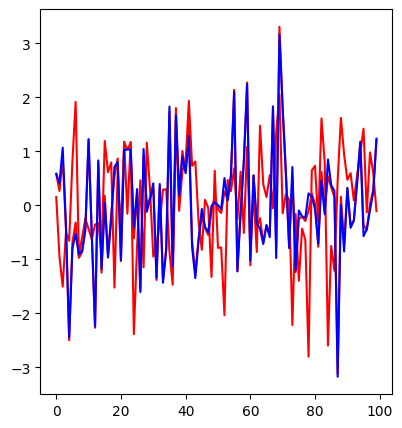

In [43]:
# plot u_derived and X_c for comparison
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(100),zscore(u_derived), color='red', label='u_derived')
plt.plot(range(100),zscore(X_c[:, 0]), color='blue', label='X_c')

In [29]:
X_approx = X_c @ cca.x_loadings_.T
Y_approx = Y_c @ cca.y_loadings_.T


In [31]:
X_approx

array([[ 0.10704298,  0.3566069 ,  0.38068902],
       [ 0.75614051,  0.74033844, -0.61951111],
       [ 1.25461463,  1.41505316, -0.68070081],
       [ 0.21511458, -0.01796099, -0.60144031],
       [-0.29632917, -1.37982195, -1.78420512],
       [-0.72564661, -0.90179823,  0.23864806],
       [-1.29758162, -1.18618293,  1.21989442],
       [ 0.24691404, -0.25523778, -1.12678258],
       [ 0.05116896, -0.36510469, -0.81426956],
       [ 0.03886531, -0.17919697, -0.43596252],
       [ 0.53111174,  0.96880172,  0.39967654],
       [ 0.10914322, -0.18883809, -0.63947188],
       [-0.41179714, -1.36623659, -1.45403029],
       [ 0.42283165,  0.70232101,  0.18990335],
       [ 0.15694299, -0.45088432, -1.25313954],
       [-0.7195646 , -0.49732108,  0.97498023],
       [-0.59157035, -0.88772394, -0.0892123 ],
       [-0.55449098, -0.5233632 ,  0.4906455 ],
       [ 1.12356526,  1.15058544, -0.82660511],
       [-0.16316057,  0.26410757,  0.92212297],
       [-0.05049404, -0.52177262, -0.837